# Data processing

# Libraries

In [6]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample

from constants import NUM_SELECTED, CAT_SELECTED, SELECTED_FEATURES

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import LearningCurveDisplay

from tqdm import tqdm

import warnings
from sklearn.exceptions import DataConversionWarning

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.decomposition import PCA

import optuna
from optuna.samplers import TPESampler

warnings.simplefilter(action='ignore', category=DataConversionWarning)
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import LearningCurveDisplay

from tqdm import tqdm

import warnings
from sklearn.exceptions import DataConversionWarning

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.decomposition import PCA

import optuna
from optuna.samplers import TPESampler
import pickle

warnings.simplefilter(action='ignore', category=DataConversionWarning)

# Data Loading

In [3]:
X_test = pd.read_parquet("../../../../../data/interim/copper/X_test.parquet")
y_test = pd.read_parquet("../../../../../data/interim/copper/y_test_cat.parquet")

X_train = pd.read_parquet("../../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet("../../../../../data/interim/copper/y_train_cat.parquet")

# Pipe Setting

In [4]:
NEW_FEATURES_NAME = [f"PCA_{i}" for i in range(4)] + [f"GLOBAL_REGION_{i}" for i in range(3)]

over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('pca', PCA(n_components=4))
    ])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num_pca', numeric_transformer, NUM_SELECTED),
            ('cat', categorical_transformer, ["GLOBAL_REGION"])
        ]
    )

rkf= RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

# Hyperparameter tunnig

In [ ]:
def objective(trial):

    params = dict()
    params['n_estimators'] = trial.suggest_int('n_estimators', 1, 100)
    params['max_depth'] = trial.suggest_int('max_depth', 2, 7)
    params['max_features'] = trial.suggest_int('max_features', 1, 27)
    params['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 50)
    params['min_samples_leaf'] = trial.suggest_int('min_samples_leaf', 1, 30)
    params['random_state'] = trial.suggest_int('random_state', 1, 100)
    params['class_weight'] = 'balanced'
    params['n_jobs'] = -1

    over = SMOTE(sampling_strategy="auto", 
                 random_state=trial.suggest_int('random_state_smote', 1, 100))
    
    under = RandomUnderSampler(sampling_strategy="auto",
                               random_state=trial.suggest_int('random_state_under', 1, 100))

    steps_list =[('preprocessor', preprocessor),
        ('over', over),
        ('under', under),]


    model = RandomForestClassifier(**params)

    steps_list.append(('classifier', model))

    pipe = ImbPipeline(steps_list)

    scores = cross_val_score(pipe, X_train[NUM_SELECTED + ["GLOBAL_REGION"]], y_train, cv=rkf, scoring="roc_auc")

    return np.mean(scores), np.std(scores)

study = optuna.create_study(directions=['maximize', 'minimize'], sampler=TPESampler())
study.optimize(objective, n_trials=5000)

A saída de streaming foi truncada nas últimas 5000 linhas.
[I 2024-11-20 18:32:05,532] Trial 0 finished with values: [0.6605377906976744, 0.07917661672559784] and parameters: {'n_estimators': 94, 'max_depth': 4, 'max_features': 16, 'min_samples_split': 25, 'min_samples_leaf': 8, 'random_state': 65}.
[I 2024-11-20 18:32:06,643] Trial 1 finished with values: [0.6861780177187153, 0.0898053184404471] and parameters: {'n_estimators': 18, 'max_depth': 3, 'max_features': 17, 'min_samples_split': 11, 'min_samples_leaf': 23, 'random_state': 1}.
[I 2024-11-20 18:32:09,141] Trial 2 finished with values: [0.6626695736434108, 0.10749418717678384] and parameters: {'n_estimators': 85, 'max_depth': 2, 'max_features': 26, 'min_samples_split': 11, 'min_samples_leaf': 15, 'random_state': 41}.
[I 2024-11-20 18:32:11,016] Trial 3 finished with values: [0.6894483665559246, 0.1003755477780657] and parameters: {'n_estimators': 57, 'max_depth': 3, 'max_features': 5, 'min_samples_split': 8, 'min_samples_leaf': 

In [10]:
with open('study_rf_feat_modeling.pkl', 'rb') as file:

    study = pickle.load(file)

In [15]:
fig = optuna.visualization.plot_pareto_front(
    study, 
    target_names=["Média ROC-AUC", "Desvio Padrão ROC-AUC"]
)

# Remove colorbars from each trace
for trace in fig.data:
    if "marker" in trace and "colorbar" in trace.marker:
        trace.marker.colorbar = None

fig.update_layout(
    width=800,  # Set the width in pixels
    height=600,  # Set the height in pixels
    title="Curva de Pareto",  # Set the title
    coloraxis_showscale=False  # Remove the colorbars
)

# Show the plot
fig.show()

In [79]:
study.trials[2168].params

{'n_estimators': 37,
 'max_depth': 5,
 'max_features': 27,
 'min_samples_split': 29,
 'min_samples_leaf': 22,
 'random_state': 51}

# Learning Curve

In [92]:
params = study.trials[2168].params
params['n_jobs'] = -1
params['class_weight'] = 'balanced'

over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('pca', PCA(n_components=4))
    ])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num_pca', numeric_transformer, NUM_SELECTED),
            ('cat', categorical_transformer, ["GLOBAL_REGION"])
        ]
    )

steps_list =[('preprocessor', preprocessor),
        ('over', over),
        ('under', under),]


model = RandomForestClassifier(**params)

steps_list.append(('classifier', model))

pipe = ImbPipeline(steps_list)

pipe.fit(X_train[NUM_SELECTED + ["GLOBAL_REGION"]], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=4))]),
                                                  ['COPPER_GRADE',
                                                   'GOLD_DENSITY',
                                                   'LOG_10_COPPER_GRADE',
                                                   'INITIAL_COST_PER_AMOUNT',
                                                   'INITIAL_COST',
                                                   'LOG_10_GOLD_DENSITY',
                                                   'LOG_10_INITIAL_COST',
                                                   'LOG_10_INITIAL_COST_PER_AMOUNT']),
                                                 ('cat',
                                                  Pipeline(steps=[('binary_encoder',
                                                                   BinaryEncoder())]),
                                                  ['GLOBAL_REGION'])])),
                ('over', SMOTE()), ('under', RandomUnderSampler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        max_features=27, min_samples_leaf=22,
                                        min_samples_split=29, n_estimators=37,
                                        n_jobs=-1, random_state=51))])

# Bootstraping Error Extimation

## Treino

In [93]:
y_prob = pipe.predict_proba(X_train)[:, 1]

roc_auc = roc_auc_score(y_train.values, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8529


In [94]:
bootstrap_dataframes = [X_train.sample(X_train.shape[0], replace=True) for _ in range(1000)]

lines = []
roc_auc_scores = []

for i, df in tqdm(enumerate(bootstrap_dataframes)):

    y_prob = pipe.predict_proba(df)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.loc[df.index].values, y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})
    lines.append(line_df)

    roc_auc = roc_auc_score(y_train.loc[df.index].values, y_prob)
    roc_auc_scores.append(roc_auc)

roc_df = pd.concat(lines)

1000it [00:27, 35.91it/s]


In [95]:
np.quantile(roc_auc_scores, [0.05, 0.5, 0.95])

array([0.7426814 , 0.86058186, 0.94201611])

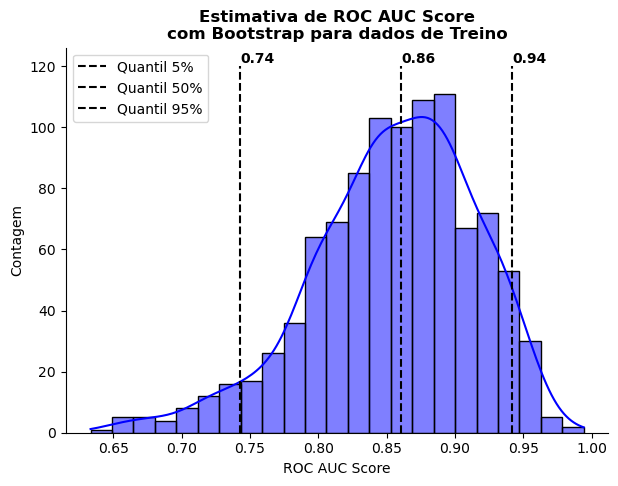

In [96]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(roc_auc_scores, kde=True, ax=ax, color = 'blue')
ax.set_title("Estimativa de ROC AUC Score\ncom Bootstrap para dados de Treino", weight='bold')
ax.set_xlabel("ROC AUC Score")
ax.set_ylabel("Contagem")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for quant, frac in zip(np.quantile(roc_auc_scores, [0.05, 0.5, 0.95]), [5, 50, 95]):
    ax.vlines(quant, 0, 120, color='black', linestyles='--', label=f"Quantil {frac}%")
    ax.text(quant, 121, f"{quant:.2f}", color='black', weight='bold')

ax.legend()



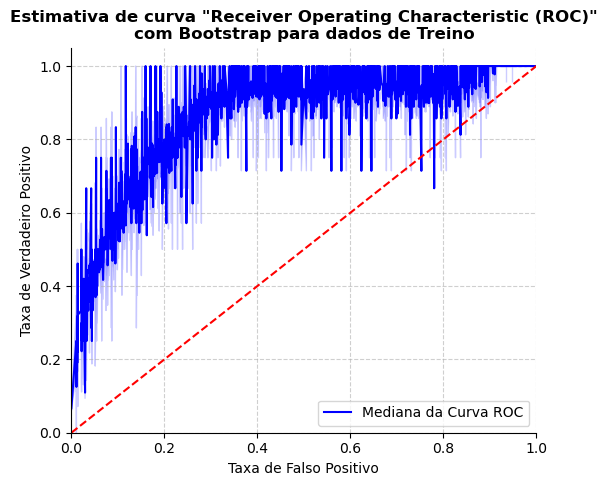

In [97]:
plt.figure(figsize=(6, 5))
ax = sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median', color='blue', label='Mediana da Curva ROC')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Estimativa de curva "Receiver Operating Characteristic (ROC)"\ncom Bootstrap para dados de Treino', weight='bold')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Teste

In [91]:
y_prob = pipe.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test.values, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.6543


In [88]:
bootstrap_dataframes = [X_test.sample(X_test.shape[0], replace=True) for _ in range(1000)]

def get_bootstrap_roc_curve(pipe, df, y_test, i):

    y_prob = pipe.predict_proba(df)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test.loc[df.index].values, y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})

    return line_df

lines = [get_bootstrap_roc_curve(pipe, df, y_test, i) for i, df in tqdm(enumerate(bootstrap_dataframes))]

def get_roc_auc(pipe, df, y_test):
    y_prob = pipe.predict_proba(df)[:, 1]
    roc_auc = roc_auc_score(y_test.loc[df.index].values, y_prob)
    return roc_auc

roc_auc_scores = [get_roc_auc(pipe, df, y_test) for df in tqdm(bootstrap_dataframes)]

roc_df = pd.concat(lines)


1000it [00:25, 38.71it/s]
100%|██████████| 1000/1000 [00:27<00:00, 36.28it/s]


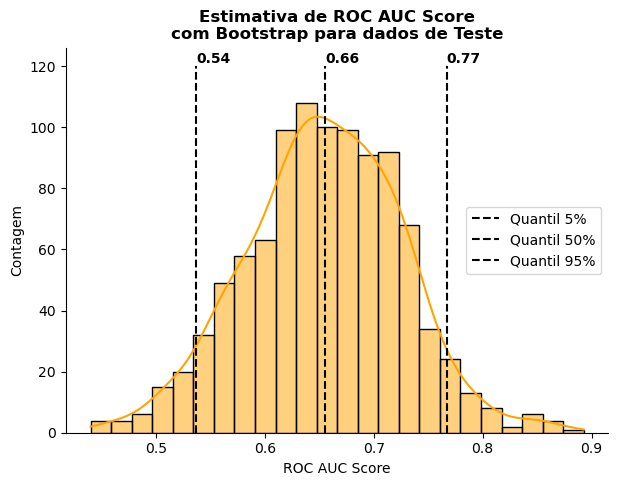

In [89]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(roc_auc_scores, kde=True, ax=ax, color = 'orange')
ax.set_title("Estimativa de ROC AUC Score\ncom Bootstrap para dados de Teste", weight='bold')
ax.set_xlabel("ROC AUC Score")
ax.set_ylabel("Contagem")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for quant, frac in zip(np.quantile(roc_auc_scores, [0.05, 0.5, 0.95]), [5, 50, 95]):
    ax.vlines(quant, 0, 120, color='black', linestyles='--', label=f"Quantil {frac}%")
    ax.text(quant, 121, f"{quant:.2f}", color='black', weight='bold')

ax.legend()

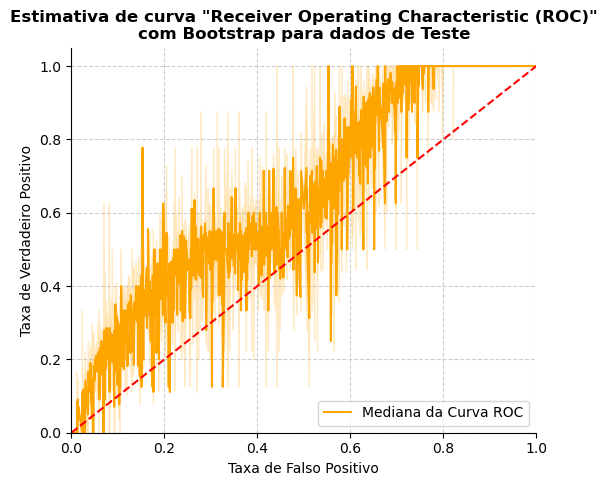

In [90]:
plt.figure(figsize=(6, 5))
ax = sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median', color='orange', label='Mediana da Curva ROC')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Estimativa de curva "Receiver Operating Characteristic (ROC)"\ncom Bootstrap para dados de Teste', weight='bold')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()